# Uncertainty

This notebook examines uncertainty in Atomica, going through

- How uncertainty in model inputs is entered
- How to perform simulations that are sampled from the distribution of parameters with uncertainty
- How to perform analyses that incorporate uncertainty

## Specifying uncertainty

Fundamentally, uncertainty enters Atomica via the data entry spreadsheets. Both the databook and program book have columns that can be used to enter uncertainty. 

In the databook, uncertainty can be added to any TDVE table - that is, any of the sub-tables within the databook for each quantity. By default, those columns are not produced when the databook is written e.g. with 

    proj.data.save('databook.xlsx')
    
If you want to include those columns, use the `write_uncertainty` options:

    proj.data.save('databook.xlsx',write_uncertainty=True)
    
This will add an 'uncertainty' column to all tables in the databook. If you only want to add uncertainty to a small number of quantities, you can simply insert an extra column for the tables that you want to add uncertainty to, by selecting the other cells and moving them over. The example below shows how an uncertainty column has been added to the 'Screened people' table and not to the 'All people with condition' table:

![image1](assets/databook_uncertainty.png)


<div class="alert alert-info">
Uncertainty should be entered as a standard deviation, with the same units as the quantity itself
</div>

In the example above, it would be accurate to state that the 2016 value for the number of screened people in the male rural population is $214 \pm 20$. Mathematically, the entry above corresponds to specifying that the distribution of screened people in the male rural population has a mean of 214 and a standard deviation of 20. 

For the program book, uncertainty appears in two places - in the spending/coverage sheet, and in the outcome sheet, as shown below. These columns are always present in the program book.


![image2](assets/progbook_spending_uncertainty.png)
![image3](assets/progbook_outcome_uncertainty.png)


To limit complexity in data entry, only a single uncertainty value can be entered for each quantity. That is, in the databook and spending/coverage sheet, uncertainty cannot vary over time, and in the outcome sheet, the uncertainty is specified at the parameter-population level, and applies to all programs reaching that parameter. 

## Sampling inputs

We have seen above how to enter uncertainty in the databook and program book. These uncertainties are loaded into the corresponding `ProjectData` and `ProgramSet` objects in Atomica. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('..')

In [2]:
import atomica as at
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sciris as sc
np.random.seed(3)
testdir = '../../tests/'

P = at.Project(framework=testdir + 'test_uncertainty_framework.xlsx', databook=testdir + 'test_uncertainty_databook.xlsx')
P.load_progbook(testdir + 'test_uncertainty_high_progbook.xlsx')

low_uncertainty_progset = at.ProgramSet.from_spreadsheet(testdir + 'test_uncertainty_low_progbook.xlsx',project=P)
high_uncertainty_progset = at.ProgramSet.from_spreadsheet(testdir + 'test_uncertainty_high_progbook.xlsx',project=P)
default_budget = at.ProgramInstructions(start_year=2018, alloc=P.progsets[0])
doubled_budget = default_budget.scale_alloc(2)


WARNING {framework.py:1041} - Parameter "screen" is in rate units and a maximum value of "1" has been entered. Rates in the framework should generally not be limited to "1"


WARNING {framework.py:1041} - Parameter "diag" is in rate units and a maximum value of "1" has been entered. Rates in the framework should generally not be limited to "1"


WARNING {framework.py:1041} - Parameter "initiate" is in rate units and a maximum value of "1" has been entered. Rates in the framework should generally not be limited to "1"


WARNING {framework.py:1041} - Parameter "loss" is in rate units and a maximum value of "1" has been entered. Rates in the framework should generally not be limited to "1"


WARNING {framework.py:1041} - Parameter "fail_rate" is in rate units and a maximum value of "1" has been entered. Rates in the framework should generally not be limited to "1"


Elapsed time for running "default": 0.0350s


Above, we have loaded in a databook with uncertainty values, and also loaded in two different program books, one with low uncertainty, and one with high uncertainty. We can inspect the objects to see how the uncertainty entered in the spreadsheets is reflected in code. 

In [3]:
P.data.tdve['all_screened'].ts[0]

[<class 'atomica.utils.TimeSeries'>]
————————————————————————————————————————————————————————————————————————
Methods:
  copy()                  interpolate()           remove_between()        
  get()                   remove()                sample()                
  get_arrays()            remove_after()          insert()                
  remove_before()         
————————————————————————————————————————————————————————————————————————
Properties:
  has_data                has_time_data           
————————————————————————————————————————————————————————————————————————
  _sampled: False
assumption: None
     sigma: 20.0
         t: [2016]
     units: 'Number'
      vals: [214.0]
————————————————————————————————————————————————————————————————————————

The uncertainty value is attached to the underlying `TimeSeries` objects, and stored in the `sigma` property. When running a simulation, we specify a `ParameterSet` and optionally a `ProgramSet`:

Elapsed time for running "default": 0.0427s


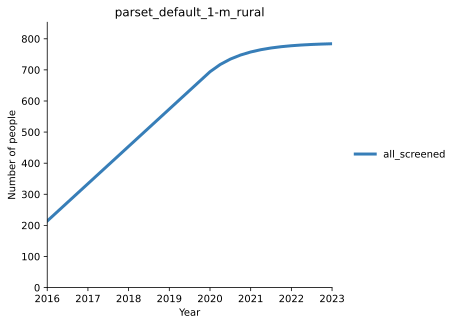

In [4]:
parset = P.parsets[0]
res = P.run_sim(parset)
d = at.PlotData(res,'all_screened',pops='m_rural')
at.plot_series(d);

If there is uncertainty, we can obtain a sampled epidemiological prediction by sampling from all of the quantities containing uncertinty. For example, replacing the value of `214` above with a sample from the distribution $\ \mathcal{N}(214,20)$ - along with all of the other quantities. The input to the model is effectively a parameter set derived from the original set of parameters, but with values replaced by sampled values where appropriate. You can obtain a sampled parameter set simply by calling the `ParameterSet.sample()` method:

In [5]:
sampled_parset = parset.sample()

Now compare the values for the screening parameter in the original parset and the sampled parset:

In [6]:
print('Original parameters: %.2f' % (parset.pars['all_screened'].ts['m_rural'].vals[0]))
print('Sampled parameters: %.2f' % (sampled_parset.pars['all_screened'].ts['m_rural'].vals[0]))

Original parameters: 214.00
Sampled parameters: 249.77


The original parameters contain the values entered in the databook, while the sampled parameters have the values perturbed by the sampling. Although the sampled parameters retain the original uncertainty values, you can only perform sampling once:

In [7]:
try:
    sampled_parset.sample()
except Exception as e:
    print(e)

Sampling has already been performed - can only sample once


To run a sampled simulation, it is thus only necessary to pass the sampled `ParameterSet` into `Project.run_sim` instead of the original parameters:

Elapsed time for running "default": 0.0459s


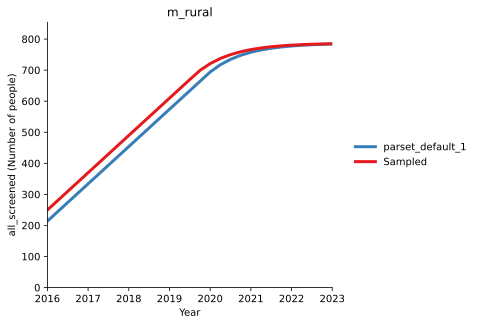

In [8]:
sampled_res = P.run_sim(sampled_parset,result_name='Sampled')
d = at.PlotData([res,sampled_res],'all_screened',pops='m_rural')
at.plot_series(d,axis='results');

Exactly the same procedure is used for programs - the `ProgramSet` has a `sample()` method which returns a sampled `ProgramSet` that can be used instead of the original `ProgramSet` to perform a sampled simulation:

In [9]:
sampled_progset = high_uncertainty_progset.sample()
res = P.run_sim(parset,high_uncertainty_progset,progset_instructions=default_budget,result_name='Original')
sampled_res = P.run_sim(parset,sampled_progset,progset_instructions=default_budget,result_name='Sampled')
d = at.PlotData([res,sampled_res],'all_screened',pops='m_rural')
at.plot_series(d,axis='results');

Elapsed time for running "default": 0.0468s


Elapsed time for running "default": 0.0456s


Of course, we can combine the sampled parset and the sampled progset in a single simulation to sample from both sources of uncertainty simultaneously:

In [10]:
sampled_res = P.run_sim(sampled_parset,sampled_progset,progset_instructions=default_budget,result_name='Sampled')
d = at.PlotData([res,sampled_res],'all_screened',pops='m_rural')
at.plot_series(d,axis='results');

Elapsed time for running "default": 0.0499s


One issue when sampling is that of satisfying initial conditions. Databooks often require some work to ensure that none of the initial compartment sizes are negative. If uncertainties are specified for characteristics that are used for initialization, it is possible that the independently-sampled characteristic values yield a bad initialization (where some of the compartment sizes are negative, or the characteristic values are otherwise inconsistent). If this happens, a `BadInitialization` error is raised. Therefore, to write reliable sampling code, it is essential to catch this exception:

In [11]:
np.random.seed(1) # This seed provides a BadInitialization at the next iteration
sampled_parset = parset.sample()
try:
    sampled_res = P.run_sim(sampled_parset)
except at.BadInitialization as e:
    print(e)

Negative initial popsizes:
Compartment f_rural scr - Calculated -11.235128
Characteristic 'all_people': Target value = [1101.]
	Compartment undx: Computed value = 630.235128
	Compartment scr: Computed value = -11.235128
	Compartment dx: Computed value = 100.000000
	Compartment tx: Computed value = 234.000000
	Compartment con: Computed value = 148.000000
Characteristic 'all_screened': Target value = [470.76487173]
	Compartment scr: Computed value = -11.235128
	Compartment dx: Computed value = 100.000000
	Compartment tx: Computed value = 234.000000
	Compartment con: Computed value = 148.000000



When this error occurs, the correct thing to do is usually to just sample again on the assumption that other samples may satisfy the initial conditions. Thus, sampling would be carried out within a `while` loop that continues until a simulation is successfully run. To automate this, we can use `Project.run_sampled_sims` which functions similarly to `Project.run_sim()` except that it incorporates a sampling step together with automated resampling if the initial conditions are unsatisfactory

In [12]:
sampled_res = P.run_sampled_sims(parset)
print(sampled_res)

Elapsed time for running "default": 0.0393s


[[<atomica.results.Result at 0x7f9eb8497f20>
[<class 'atomica.results.Result'>, <class 'atomica.utils.NamedItem'>]
————————————————————————————————————————————————————————————————————————
Methods:
  charac_names()          export_raw()            get_variable()          
  check_for_nans()        get_alloc()             link_names()            
  comp_names()            get_coverage()          par_names()             
  copy()                  get_equivalent_alloc()  plot()                  
————————————————————————————————————————————————————————————————————————
Properties:
  dt                      pop_labels              used_programs           
  framework               t                       
————————————————————————————————————————————————————————————————————————
    created: datetime.datetime(2025, 3, 10, 3, 11, 40, 671041,
             tzinfo=tzutc())
    gitinfo: {'branch': 'Detached head (no branch)', 'hash':
             '7ec5502', 'date': '2 [...]
      model: <atomica.mod

Note that the return value is a list of results, rather than just a `Result` like with `Project.run_sim()`. Typically, uncertainties require working with multiple samples. Thus, you can also pass in a number of samples, and `Project.run_sampled_sims()` will return the required number of sampled results:

In [13]:
sampled_res = P.run_sampled_sims(parset,n_samples=5)
print(len(sampled_res))

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 19.80it/s]

 80%|████████  | 4/5 [00:00<00:00, 19.76it/s]

100%|██████████| 5/5 [00:00<00:00, 20.34it/s]

5


When running multiple sampled simulations, a progress bar with estimated time remaining will be displayed.

## Analysis

Now that we are able to run simulations with sampled parameters, the next question is how to produce analysis outputs such as plots that have error bars or otherwise visually represent uncertainty. The first step to doing this is to obtain a collection of results. The number of samples required loosely depends on the number of quantities with uncertainty - a general rule of thumb though is that the number of samples required would generally be on the order of 50-200. 

In [14]:
sampled_res = P.run_sampled_sims(parset,n_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:07, 13.47it/s]

  4%|▍         | 4/100 [00:00<00:07, 12.57it/s]

  7%|▋         | 7/100 [00:00<00:05, 16.13it/s]

  9%|▉         | 9/100 [00:00<00:05, 16.34it/s]

 12%|█▏        | 12/100 [00:00<00:04, 18.64it/s]

 15%|█▌        | 15/100 [00:00<00:04, 18.83it/s]

 17%|█▋        | 17/100 [00:00<00:04, 18.76it/s]

 20%|██        | 20/100 [00:01<00:04, 18.17it/s]

 23%|██▎       | 23/100 [00:01<00:03, 20.10it/s]

 26%|██▌       | 26/100 [00:01<00:04, 18.27it/s]

 28%|██▊       | 28/100 [00:01<00:04, 16.35it/s]

 30%|███       | 30/100 [00:01<00:04, 14.05it/s]

 33%|███▎      | 33/100 [00:01<00:04, 16.11it/s]

 35%|███▌      | 35/100 [00:02<00:03, 16.54it/s]

 37%|███▋      | 37/100 [00:02<00:03, 16.58it/s]

 39%|███▉      | 39/100 [00:02<00:03, 16.85it/s]

 42%|████▏     | 42/100 [00:02<00:03, 19.33it/s]

 45%|████▌     | 45/100 [00:02<00:03, 15.60it/s]

 48%|████▊     | 48/100 [00:02<00:03, 16.93it/s]

 51%|█████     | 51/100 [00:02<00:02, 18.78it/s]

 54%|█████▍    | 54/100 [00:03<00:03, 13.37it/s]

 56%|█████▌    | 56/100 [00:03<00:03, 13.34it/s]

 58%|█████▊    | 58/100 [00:03<00:03, 13.58it/s]

 60%|██████    | 60/100 [00:03<00:02, 14.06it/s]

 62%|██████▏   | 62/100 [00:03<00:02, 13.87it/s]

 65%|██████▌   | 65/100 [00:04<00:02, 16.13it/s]

 67%|██████▋   | 67/100 [00:04<00:02, 15.84it/s]

 70%|███████   | 70/100 [00:04<00:01, 17.58it/s]

 72%|███████▏  | 72/100 [00:04<00:01, 17.00it/s]

 74%|███████▍  | 74/100 [00:04<00:01, 17.61it/s]

 76%|███████▌  | 76/100 [00:04<00:01, 17.38it/s]

 78%|███████▊  | 78/100 [00:04<00:01, 17.48it/s]

 80%|████████  | 80/100 [00:04<00:01, 13.36it/s]

 82%|████████▏ | 82/100 [00:05<00:01, 12.99it/s]

 85%|████████▌ | 85/100 [00:05<00:00, 16.18it/s]

 88%|████████▊ | 88/100 [00:05<00:00, 17.94it/s]

 90%|█████████ | 90/100 [00:05<00:00, 16.35it/s]

 92%|█████████▏| 92/100 [00:05<00:00, 15.60it/s]

 94%|█████████▍| 94/100 [00:05<00:00, 14.65it/s]

 96%|█████████▌| 96/100 [00:05<00:00, 15.14it/s]

 99%|█████████▉| 99/100 [00:06<00:00, 17.87it/s]

100%|██████████| 100/100 [00:06<00:00, 16.28it/s]

For comparison, we will also run a 'baseline' simulation with no sampling. A plot of the baseline results looks like this:

In [15]:
baseline = P.run_sim(parset)
d = at.PlotData(baseline,outputs=['screen','diag','initiate'],pops='m_rural')
at.plot_series(d);

Elapsed time for running "default": 0.0341s


### Basic plotting

The normal sequence for plotting is that we would 

1. Instantiate a `PlotData` object with the quantities to plot. Effectively, this operation is mapping a `Result` to a `PlotData`
2. Call a plotting library function to generate the plot

Plots generated with the plotting library compare multiple results (e.g. different scenarios) rather than showing uncertainty computed over an ensemble of results. Further, they only take in a single `PlotData` instance where the results to compare have been included in the same `PlotData` object. 

To work with uncertainty, instead of plotting a single `PlotData` object, we instead plot a collection of `PlotData` objects. And plots are generated using a different set of plotting functions that take in multiple `PlotData` instances and use them to compute and display uncertainties (e.g. as error bars or as shaded areas).

This functionality is accessed via the `Ensemble` class. The `Ensemble` class is designed to store and plot ensembles of results. Internally, it stores a list of `PlotData` objects - one for each sample. It also contains a 'mapping function' that takes in results and returns a `PlotData` instance. To use an Ensemble, first we need to define a mapping function. In the simplest case, this looks just like a normal call to `PlotData()`:

In [16]:
mapping_function = lambda x: at.PlotData(x,outputs=['screen','diag','initiate'],pops='m_rural')

Then, we create an `Ensemble`:

In [17]:
ensemble = at.Ensemble(mapping_function=mapping_function)

We then need to load all of the results into the mapping function. Similar to Python's built-in `set` class, there are two ways of inserting the results

- One by one, using `Ensemble.add(result)`
- All at once, using `Ensemble.update(list_of_results)`

In our case, we already have a list of results generated by `P.run_sampled_sims`, so we can go ahead and use `Ensemble.update()` to insert them

In [18]:
ensemble.update(sampled_res)

Finally, we can make some plots. To start with, let's make a plot of the time series like the one shown above for the baseline results, but with uncertainty this time:

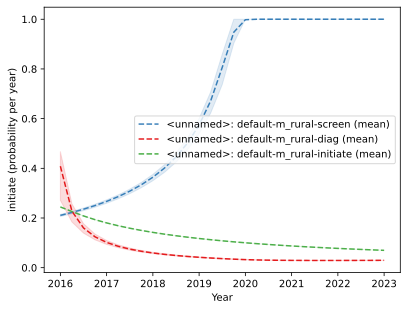

In [19]:
ensemble.plot_series();

As we have only loaded in the sampled results, the dashed line corresponds to the median of the samples. The shaded areas show the area between the first and third quartiles for the samples. To start with, instead of showing the median of the samples, it is generally more appropriate to show the actual baseline results. To do this, we can load the baseline results into the Ensemble and then regenerate the plot.

<div class="alert alert-warning">
The baseline results need to have the same names as the sampled results. If you do not explicitly specify names, `Project.run_sampled_sims` produces default names that avoid collisions between multiple instructions. However, `Project.run_sim` produces default names that avoid collisions with other results stored in the project. Therefore, it may be necessary to explicitly set or change the result names if the names were set differently.
</div>

In this case, the baseline results need to have their name changed to `'default'` to match the sampled results:

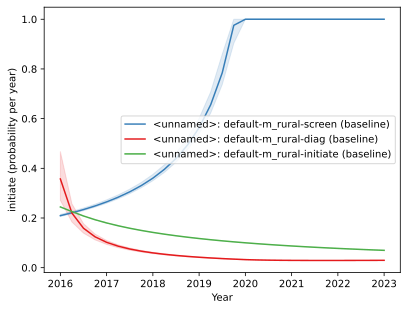

In [20]:
baseline.name = 'default'
ensemble.set_baseline(baseline)
ensemble.plot_series();

As with the rest of the plotting library, the legend is 'maximally informative' in that it contains as much information as possible. This is because the most appropriate labelling for the figure (whether the axis labels, titles, or legend entries) varies greatly with context, and it is often necessary to relabel the figure on a plot-by-plot basis. This relabelling is facilitating by having all of the necessary content on the figure, rather than having to keep track of it separately. Thus, it is expected that the labels may need to be edited afterwards depending on usage.

The `'<unnamed'>` string corresponds to the name of the ensemble. We hadn't given the ensemble a name, but naming the ensemble can be useful if you want to superimpose multiple ensembles on the same plot. The ensemble can be named at construction, or at any point subsequently:

In [21]:
ensemble.name = 'Example'
ensemble.plot_series();

Now, the baseline results are displayed as solid lines. Other types of plots can be generated too. 

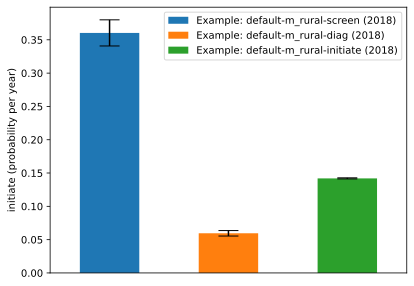

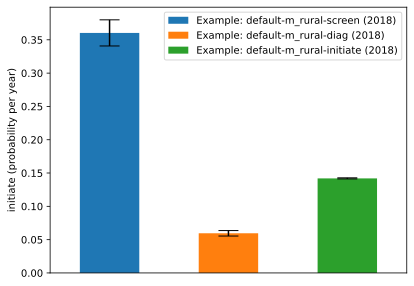

In [22]:
ensemble.plot_bars(years=2018)

Because the `Ensemble` stores `PlotData` objects, you can perform any aggregation operations in the same way as normal. For example, we can plot the years lost to disability by integrating the number of people in the disease compartments.

In [23]:
yld = lambda x: at.PlotData(x,outputs={'disease':['undx','scr','dx','tx']},t_bins=[2018,2023],time_aggregation='integrate')

This is the usual way that this plot would be generated for a single `Result` without uncertainty, and indeed we can go ahead and generate that plot now

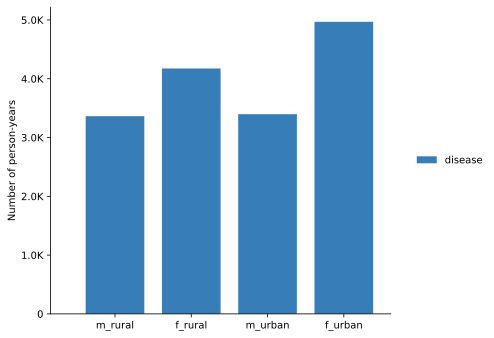

In [24]:
d = yld(baseline)
at.plot_bars(d);

With uncertainty, we simply make the plot via an `Ensemble` instead

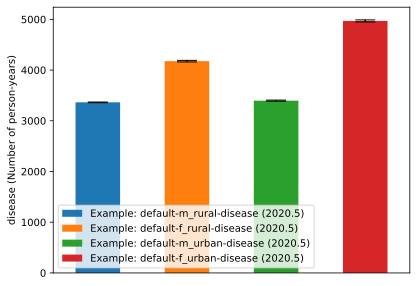

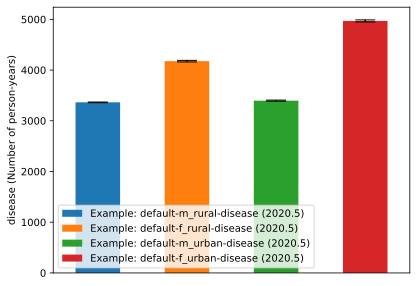

In [25]:
ensemble = at.Ensemble(name='Example',mapping_function=yld,baseline_results=baseline)
ensemble.update(sampled_res)
ensemble.plot_bars()

You can also use the `Ensemble.summary_statistics()` method to get a dataframe with summary statistics

In [26]:
ensemble.summary_statistics()

value
year result  output  pop     quantity             
NaN  default disease m_rural baseline  3362.999052
                             mean      3362.689865
                             median    3362.229674
                             max       3383.501089
                             min       3348.031225
                             Q1        3357.640676
                             Q3        3367.016381
                     f_rural baseline  4175.364625
                             mean      4174.657501
                             median    4173.735033
                             max       4217.624374
                             min       4132.233303
                             Q1        4166.075537
                             Q3        4185.514899
                     m_urban baseline  3396.464712
                             mean      3397.135096
                             median    3397.719692
                             max       3419.841094
                             min       3371.550566
                             Q1        3391.851250
                             Q3        3404.597237
                     f_urban baseline  4968.772456
                             mean      4968.806673
                             median    4966.767523
                             max       5016.001787
                             min       4911.368454
                             Q1        4954.877096
                             Q3        4983.216754

### Comparing sampled results

Moving up in complexity, a common analysis task is comparing results across scenarios. At the beginning, we instantiated two sets of instructions - one with default spending, and one with doubled spending. We will now produce samples from both of these instructions. There are two ways to approach this problem

- Storing the results in separate Ensembles
- Putting multiple results into a single Ensemble

To perform the analysis most validly, it is important to run the budget scenario in each of the instructions for the same parset and progset samples. That is, to generate a single result, it is necessary to first sample, and then use the same samples for all instructions. Written out explicitly, this would be

In [27]:
np.random.seed(3)
sampled_parset = parset.sample()
sampled_progset = high_uncertainty_progset.sample()
result_default_spend = P.run_sim(sampled_parset,sampled_progset,default_budget,result_name='Baseline')
result_doubled_spend = P.run_sim(sampled_parset,sampled_progset,doubled_budget,result_name='Doubled budget')

Elapsed time for running "default": 0.0433s


Elapsed time for running "default": 0.0477s


Comparing results across budget scenarios is extremely common, so Atomica has built-in functionality to facilitate this. You can pass multiple instructions and result names to `Project.run_sampled_sims()` to generate results as shown above  

In [28]:
sampled_res = P.run_sampled_sims(parset,high_uncertainty_progset,n_samples=100,progset_instructions=[default_budget,doubled_budget],result_names=['Baseline','Doubled budget'])
print(len(sampled_res))

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:17,  5.53it/s]

  3%|▎         | 3/100 [00:00<00:12,  7.75it/s]

  4%|▍         | 4/100 [00:00<00:12,  7.98it/s]

  5%|▌         | 5/100 [00:00<00:11,  8.49it/s]

  6%|▌         | 6/100 [00:00<00:11,  8.28it/s]

  7%|▋         | 7/100 [00:00<00:12,  7.71it/s]

  9%|▉         | 9/100 [00:01<00:11,  8.27it/s]

 11%|█         | 11/100 [00:01<00:10,  8.37it/s]

 12%|█▏        | 12/100 [00:01<00:10,  8.38it/s]

 13%|█▎        | 13/100 [00:01<00:11,  7.88it/s]

 14%|█▍        | 14/100 [00:01<00:10,  8.31it/s]

 16%|█▌        | 16/100 [00:01<00:09,  9.22it/s]

 17%|█▋        | 17/100 [00:02<00:09,  8.58it/s]

 18%|█▊        | 18/100 [00:02<00:09,  8.47it/s]

 19%|█▉        | 19/100 [00:02<00:09,  8.32it/s]

 20%|██        | 20/100 [00:02<00:09,  8.29it/s]

 21%|██        | 21/100 [00:02<00:10,  7.74it/s]

 23%|██▎       | 23/100 [00:02<00:08,  8.84it/s]

 25%|██▌       | 25/100 [00:03<00:08,  8.63it/s]

 27%|██▋       | 27/100 [00:03<00:07,  9.23it/s]

 28%|██▊       | 28/100 [00:03<00:12,  5.72it/s]

 29%|██▉       | 29/100 [00:03<00:11,  6.26it/s]

 30%|███       | 30/100 [00:03<00:10,  6.66it/s]

 31%|███       | 31/100 [00:04<00:10,  6.28it/s]

 32%|███▏      | 32/100 [00:04<00:11,  5.72it/s]

 33%|███▎      | 33/100 [00:04<00:10,  6.48it/s]

 35%|███▌      | 35/100 [00:04<00:08,  7.24it/s]

 36%|███▌      | 36/100 [00:04<00:08,  7.52it/s]

 38%|███▊      | 38/100 [00:04<00:07,  7.89it/s]

 39%|███▉      | 39/100 [00:05<00:07,  7.85it/s]

 40%|████      | 40/100 [00:05<00:07,  8.03it/s]

 42%|████▏     | 42/100 [00:05<00:07,  8.02it/s]

 44%|████▍     | 44/100 [00:05<00:06,  8.88it/s]

 45%|████▌     | 45/100 [00:05<00:06,  9.09it/s]

 46%|████▌     | 46/100 [00:05<00:05,  9.23it/s]

 48%|████▊     | 48/100 [00:06<00:06,  8.29it/s]

 49%|████▉     | 49/100 [00:06<00:06,  7.49it/s]

 50%|█████     | 50/100 [00:06<00:06,  7.75it/s]

 51%|█████     | 51/100 [00:06<00:06,  7.41it/s]

 53%|█████▎    | 53/100 [00:06<00:06,  7.25it/s]

 54%|█████▍    | 54/100 [00:06<00:06,  7.46it/s]

 55%|█████▌    | 55/100 [00:07<00:05,  7.65it/s]

 57%|█████▋    | 57/100 [00:07<00:04,  8.64it/s]

 58%|█████▊    | 58/100 [00:07<00:04,  8.44it/s]

 59%|█████▉    | 59/100 [00:07<00:04,  8.41it/s]

 60%|██████    | 60/100 [00:07<00:05,  7.14it/s]

 61%|██████    | 61/100 [00:07<00:06,  6.41it/s]

 62%|██████▏   | 62/100 [00:08<00:05,  6.75it/s]

 63%|██████▎   | 63/100 [00:08<00:08,  4.51it/s]

 64%|██████▍   | 64/100 [00:08<00:07,  5.07it/s]

 65%|██████▌   | 65/100 [00:08<00:06,  5.63it/s]

 66%|██████▌   | 66/100 [00:08<00:05,  6.18it/s]

 67%|██████▋   | 67/100 [00:08<00:04,  6.89it/s]

 69%|██████▉   | 69/100 [00:09<00:03,  8.22it/s]

 70%|███████   | 70/100 [00:09<00:03,  8.44it/s]

 71%|███████   | 71/100 [00:09<00:03,  8.19it/s]

 72%|███████▏  | 72/100 [00:09<00:03,  7.53it/s]

 73%|███████▎  | 73/100 [00:09<00:03,  7.96it/s]

 74%|███████▍  | 74/100 [00:09<00:03,  8.38it/s]

 75%|███████▌  | 75/100 [00:09<00:02,  8.78it/s]

 76%|███████▌  | 76/100 [00:09<00:02,  8.96it/s]

 77%|███████▋  | 77/100 [00:10<00:02,  8.02it/s]

 78%|███████▊  | 78/100 [00:10<00:02,  8.18it/s]

 80%|████████  | 80/100 [00:10<00:02,  8.37it/s]

 81%|████████  | 81/100 [00:10<00:02,  7.48it/s]

 83%|████████▎ | 83/100 [00:10<00:02,  7.09it/s]

 84%|████████▍ | 84/100 [00:11<00:02,  6.52it/s]

 85%|████████▌ | 85/100 [00:11<00:02,  7.12it/s]

 87%|████████▋ | 87/100 [00:11<00:01,  8.32it/s]

 89%|████████▉ | 89/100 [00:11<00:01,  7.48it/s]

 91%|█████████ | 91/100 [00:11<00:01,  8.32it/s]

 92%|█████████▏| 92/100 [00:12<00:00,  8.36it/s]

 93%|█████████▎| 93/100 [00:12<00:00,  8.31it/s]

 95%|█████████▌| 95/100 [00:12<00:00,  9.02it/s]

 96%|█████████▌| 96/100 [00:12<00:00,  7.77it/s]

 98%|█████████▊| 98/100 [00:12<00:00,  8.70it/s]

 99%|█████████▉| 99/100 [00:12<00:00,  8.16it/s]

100%|██████████| 100/100 [00:13<00:00,  7.50it/s]

100%|██████████| 100/100 [00:13<00:00,  7.66it/s]

100


The output is now a list of lists, where the inner list contains a set of results that has been generated with different instructions but the same sampled inputs. This is the input that would go to an `Ensemble` mapping function, to produce a `PlotData` instance that mixes results. Now, we can generate a plot comparing YLD in each population

In [29]:
sampled_res = P.run_sampled_sims(parset,high_uncertainty_progset,progset_instructions=[default_budget,doubled_budget],n_samples=100,result_names=['Baseline','Doubled budget'])

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:09,  9.99it/s]

  3%|▎         | 3/100 [00:00<00:10,  9.26it/s]

  4%|▍         | 4/100 [00:00<00:21,  4.42it/s]

  5%|▌         | 5/100 [00:00<00:19,  4.95it/s]

  6%|▌         | 6/100 [00:01<00:16,  5.61it/s]

  7%|▋         | 7/100 [00:01<00:14,  6.45it/s]

  9%|▉         | 9/100 [00:01<00:11,  7.91it/s]

 10%|█         | 10/100 [00:01<00:11,  7.61it/s]

 11%|█         | 11/100 [00:01<00:11,  7.60it/s]

 13%|█▎        | 13/100 [00:01<00:10,  8.26it/s]

 14%|█▍        | 14/100 [00:01<00:10,  8.31it/s]

 15%|█▌        | 15/100 [00:02<00:10,  8.15it/s]

 16%|█▌        | 16/100 [00:02<00:09,  8.40it/s]

 18%|█▊        | 18/100 [00:02<00:08,  9.45it/s]

 19%|█▉        | 19/100 [00:02<00:09,  8.81it/s]

 20%|██        | 20/100 [00:02<00:08,  9.02it/s]

 21%|██        | 21/100 [00:02<00:08,  9.20it/s]

 22%|██▏       | 22/100 [00:02<00:08,  8.86it/s]

 23%|██▎       | 23/100 [00:03<00:10,  7.55it/s]

 24%|██▍       | 24/100 [00:03<00:10,  7.15it/s]

 25%|██▌       | 25/100 [00:03<00:09,  7.64it/s]

 27%|██▋       | 27/100 [00:03<00:08,  8.27it/s]

 29%|██▉       | 29/100 [00:03<00:08,  8.65it/s]

 30%|███       | 30/100 [00:03<00:09,  7.52it/s]

 32%|███▏      | 32/100 [00:04<00:07,  8.51it/s]

 33%|███▎      | 33/100 [00:04<00:09,  7.08it/s]

 35%|███▌      | 35/100 [00:04<00:07,  8.19it/s]

 37%|███▋      | 37/100 [00:04<00:07,  8.86it/s]

 38%|███▊      | 38/100 [00:04<00:07,  8.70it/s]

 40%|████      | 40/100 [00:05<00:08,  7.25it/s]

 41%|████      | 41/100 [00:05<00:07,  7.41it/s]

 42%|████▏     | 42/100 [00:05<00:07,  7.71it/s]

 43%|████▎     | 43/100 [00:05<00:07,  7.22it/s]

 44%|████▍     | 44/100 [00:05<00:07,  7.48it/s]

 46%|████▌     | 46/100 [00:05<00:06,  8.52it/s]

 47%|████▋     | 47/100 [00:06<00:10,  5.16it/s]

 48%|████▊     | 48/100 [00:06<00:09,  5.70it/s]

 49%|████▉     | 49/100 [00:06<00:07,  6.42it/s]

 50%|█████     | 50/100 [00:06<00:08,  5.73it/s]

 52%|█████▏    | 52/100 [00:06<00:07,  6.78it/s]

 53%|█████▎    | 53/100 [00:07<00:06,  7.33it/s]

 55%|█████▌    | 55/100 [00:07<00:05,  8.43it/s]

 57%|█████▋    | 57/100 [00:07<00:05,  8.43it/s]

 58%|█████▊    | 58/100 [00:07<00:05,  7.40it/s]

 59%|█████▉    | 59/100 [00:07<00:05,  7.19it/s]

 60%|██████    | 60/100 [00:07<00:05,  7.49it/s]

 62%|██████▏   | 62/100 [00:08<00:04,  8.38it/s]

 63%|██████▎   | 63/100 [00:08<00:04,  7.96it/s]

 64%|██████▍   | 64/100 [00:08<00:05,  6.68it/s]

 66%|██████▌   | 66/100 [00:08<00:04,  7.89it/s]

 67%|██████▋   | 67/100 [00:08<00:04,  8.18it/s]

 68%|██████▊   | 68/100 [00:09<00:04,  7.57it/s]

 69%|██████▉   | 69/100 [00:09<00:03,  7.89it/s]

 70%|███████   | 70/100 [00:09<00:04,  6.88it/s]

 72%|███████▏  | 72/100 [00:09<00:03,  8.10it/s]

 74%|███████▍  | 74/100 [00:09<00:03,  8.62it/s]

 76%|███████▌  | 76/100 [00:09<00:02,  8.39it/s]

 77%|███████▋  | 77/100 [00:10<00:02,  8.04it/s]

 79%|███████▉  | 79/100 [00:10<00:03,  6.83it/s]

 80%|████████  | 80/100 [00:10<00:03,  6.66it/s]

 81%|████████  | 81/100 [00:10<00:02,  6.95it/s]

 82%|████████▏ | 82/100 [00:10<00:02,  7.02it/s]

 83%|████████▎ | 83/100 [00:11<00:02,  7.27it/s]

 85%|████████▌ | 85/100 [00:11<00:01,  7.94it/s]

 87%|████████▋ | 87/100 [00:11<00:01,  7.98it/s]

 88%|████████▊ | 88/100 [00:11<00:01,  7.99it/s]

 89%|████████▉ | 89/100 [00:11<00:01,  7.62it/s]

 91%|█████████ | 91/100 [00:11<00:01,  8.60it/s]

 92%|█████████▏| 92/100 [00:12<00:00,  8.73it/s]

 93%|█████████▎| 93/100 [00:12<00:00,  8.04it/s]

 94%|█████████▍| 94/100 [00:12<00:00,  7.11it/s]

 95%|█████████▌| 95/100 [00:12<00:00,  7.68it/s]

 96%|█████████▌| 96/100 [00:12<00:00,  7.74it/s]

 97%|█████████▋| 97/100 [00:12<00:00,  8.13it/s]

 98%|█████████▊| 98/100 [00:12<00:00,  8.59it/s]

 99%|█████████▉| 99/100 [00:12<00:00,  8.38it/s]

100%|██████████| 100/100 [00:13<00:00,  4.18it/s]

100%|██████████| 100/100 [00:13<00:00,  7.41it/s]

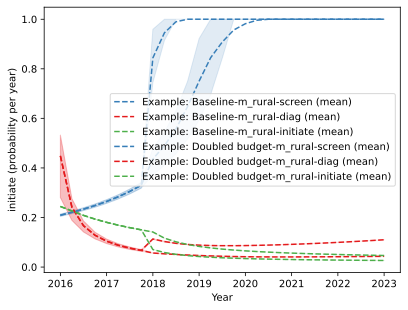

In [30]:
mapping_function = lambda x: at.PlotData(x,outputs=['screen','diag','initiate'],pops='m_rural')
ensemble = at.Ensemble(name='Example',mapping_function=mapping_function)
ensemble.update(sampled_res)
ensemble.plot_series();

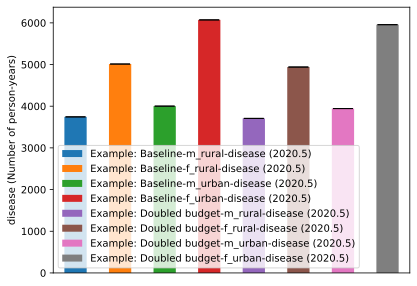

In [31]:
ensemble = at.Ensemble(name='Example',mapping_function=yld)
ensemble.update(sampled_res)
ensemble.plot_bars();

To aid comparison, it may be clearer to plot individual populations at a time. For example:

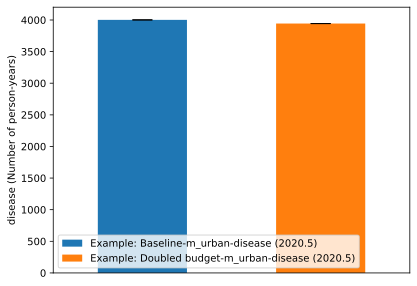

In [32]:
ensemble.plot_bars(pops='m_urban');

In this case, there isn't much difference because as shown in the time series, most of the variability is encountered in the initial simulation years. We can see this if we plot a quantity with more variability - for example, the number of undiagnosed people in the first simulation year

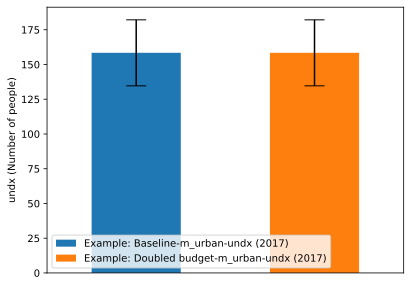

In [33]:
undx = lambda x: at.PlotData(x,outputs='undx',pops='m_urban')
ensemble = at.Ensemble(name='Example',mapping_function=undx)
ensemble.update(sampled_res)
ensemble.plot_bars(years=2017);

If you pass in a figure to `Ensemble.plot_bars()`, it will attempt to append new bars into the existing figure. For example:

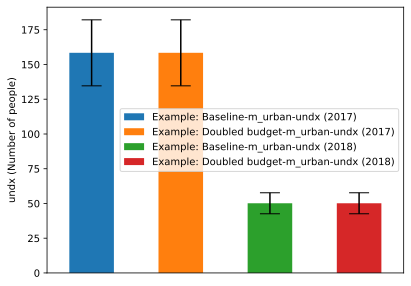

In [34]:
fig = ensemble.plot_bars(years=2017);
ensemble.plot_bars(years=2018,fig=fig);

In this case, it was not essential to do this because multiple `years` can be plotted in a single `plot_bars` call. However, you could superimpose bars from entirely separate Ensemble objects, if you wanted to compare quantities computed using different mapping functions. 

Another important type of plot is the sampled distribution of a quantity. Effectively, the entire Atomica model is a function that maps probabilitity distributions for model inputs into distributions of model outputs. These distributions can be plotted directly. For example:

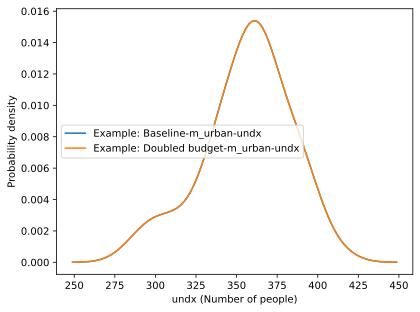

In [35]:
ensemble.plot_distribution(pops='m_urban');

The distributions that are plotted are effectively vertical cross-sections of the time series plots. They can be important to inspect to check for multi-modal distributions, or asymmetric distributions, which have implications for the validity of reporting summary statistics. 

There are two ways to compare distributions

- Within an Ensemble
    - Comparing multiple outputs/pops
    - Comparing multiple results
- Across Ensembles
   - Typically would be comparing corresponding outputs/pops
   
To cater for the former, if a `PlotData` instance contains multiple years, results, outputs, or pops, they will all be shown on the distribution figure unless filtered using arguments to `Ensemble.plot_distribution`. For the latter, subsequent calls to `Ensemble.plot_distribution` can pass in a Figure, which will superimpose the distributions onto the existing figure. For example:

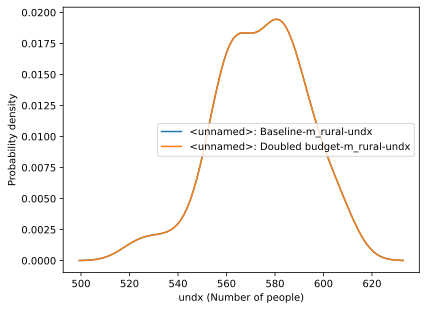

In [36]:
ensemble = at.Ensemble(lambda x: at.PlotData(x)) # All compartments
ensemble.update(sampled_res)
ensemble.plot_distribution(pops='m_rural',outputs='undx');

### Distributions of differences between results

One of the most important analyses is quantifying the difference between one budget scenario and another - for example, the improvement from optimizing the budget. In the presence of uncertainty, this difference becomes a distribution. However, samples from this distribution must be computed pairwise - from the same sampled inputs, test both budgets, compute the difference between them, and then store the difference. This can be computed by defining a mapping function that return a `PlotData` containing differences rather than raw values. For example

In [37]:
def get_differences(res):
    d1 = at.PlotData(res[0],outputs={'disease':['undx','scr','dx','tx']},t_bins=[2018,2023],time_aggregation='integrate')
    d2 = at.PlotData(res[1],outputs={'disease':['undx','scr','dx','tx']},t_bins=[2018,2023],time_aggregation='integrate')
    return d2-d1

Note that the `PlotData` class implements operators for subtraction and division, to facilitate comparing derived/aggregated quantities. We can now create an `Ensemble` with this mapping function, add the results, and plot the distribution of differences:

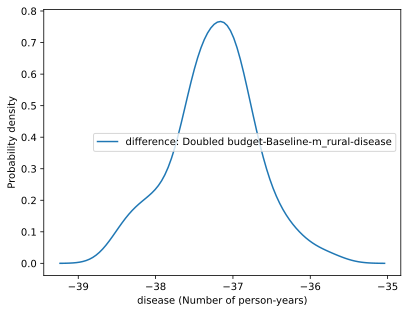

In [38]:
ensemble = at.Ensemble(get_differences,'difference')
ensemble.update(sampled_res)
ensemble.plot_distribution(pops='m_rural');

## Cascade ensembles

Plotting uncertainty on cascades is a common task. However, the cascade plotting functions normally operate directly on `Result` objects, rather than `PlotData` which forms the basis of data storage in Ensembles. For normal analysis without uncertainty, this facilitates ease of use by not requiring an intermediate `PlotData` step when producing standard cascade plots. For uncertainty, the simplest option is to construct a `PlotData` object containing the required cascade values, and to generate the plot via `Ensemble.plot_bars` (the key difference between `Ensemble.plot_bars` and `plotting.plot_bars` is that `Ensemble.plot_bars` doesn't support any stacking - which would be potentially misleading with uncertainty - and therefore supports arbitrary ordering of the bars, whereas `plotting.plot_bars` requires that the inner group consist of outputs or pops only, as these are the only valid stacking targets). 

To facilitate generation of the appropriate mapping function and arguments to `Ensemble.plot_bars`, this functionality is built into the `CascadeEnsemble` class, which inherits from `Ensemble`. The constructor for `CascadeEnsemble` takes in the name of the cascade to plot. It also requires a `ProjectFramework` to be passed in, which provides the definition of the cascade being requested:

In [39]:
cascade_ensemble = at.CascadeEnsemble(P.framework, 'main')

Results can be loaded into the cascade ensemble as normal

In [40]:
cascade_ensemble.update(sampled_res)

A cascade plot can then be plotted using `CascadeEnsemble.plot_multi_cascade()`:

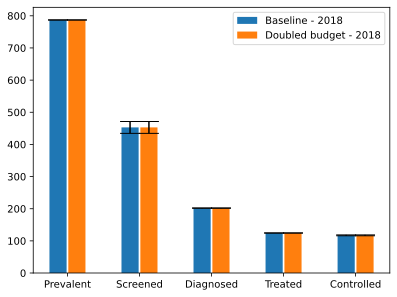

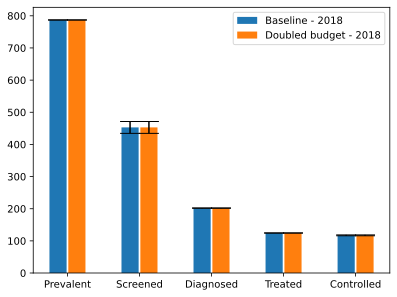

In [41]:
cascade_ensemble.plot_multi_cascade(years=2018)

Notice how the bars are automatically grouped by cascade stage and labelled appropriately. It's also possible to call standard plotting functions that are inherited from the `Ensemble` class. For example, we could plot the time series of cascade stages using `Ensemble.plot_series`:

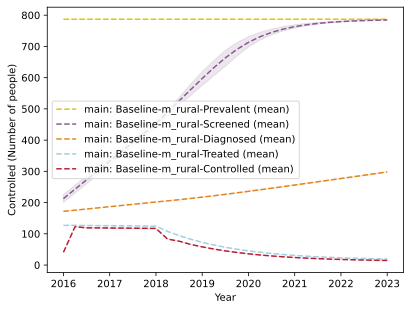

In [42]:
cascade_ensemble.plot_series(results='Baseline',pops='m_rural');

### Virtual stages

Normal cascades must be formed from compartments and characteristics only, and these stages are automatically validated to ensure proper nesting. However, because `CascadeEnsemble.plot_multi_cascade` is based around `PlotData` it is possible to display a cascade-like plot where stages are defined using arbitrary `PlotData` operations. That is, the `CascadeEnsemble` does not require that the cascade is actually valid. This opens up the possibility of generating cascade-like plots with 'virtual stages' that don't actually otherwise exist. An example from an actual application is the introduction of a 'Pre-diagnosed' stage where application data has (separately) indicated that about 80% of screened individual would be in this pre-diagnosed stage. The cascade could be defined as:

In [43]:
cascade = {
    'Prevalent':'all_people',
    'Screened':'all_screened',
    'Pre-diagnosed':'0.8*all_screened',
    'Diagnosed':'all_dx',
    'Treated':'all_tx',
    'Controlled':'all_con'
}

noting that the 'pre-diagnosed' stage is the result of a calculation and is thus not a compartment or characteristic at all. The cascade specification here is simply any `output` dict supported by `PlotData`. We can then create a `CascadeEnsemble` using this cascade, and plot it

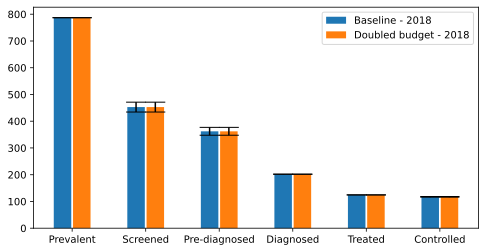

In [44]:
cascade_ensemble = at.CascadeEnsemble(P.framework, cascade)
cascade_ensemble.update(sampled_res)
fig = cascade_ensemble.plot_multi_cascade(years=2018)
fig.set_size_inches(8,4)

<div class="alert alert-success">
Notice that because the model outputs are converted to `PlotData` on a per-sample basis, uncertainty is automatically propagated to the derived quantity (i.e. 'pre-diagnosed' has uncertainty even though it was defined on the fly). This would be the case for any `PlotData` operation. 
</div>


## Memory-limited environments

A common issue that may occur when sampling large models is that there may be insufficient RAM to store all of the `Result` objects in memory prior to adding them to an `Ensemble`. The `PlotData` stored within an `Ensemble` is typically orders of magnitude smaller than the raw results - in the first instance, it only contains a small subset of the model outputs. A large model might have on the order of 150 parameters, 50 compartments, and 150 links. A typical `Ensemble` may have track 5-10 quantities, which represents a ~50x reduction in size. Further, the raw output has values at every timestep, which could be on the order of 100 values (e.g. a 25 year simulation with quarterly timesteps) but it may only be desired to compare simulations for a few time points - which could provide another ~20x reduction in size. 

In sum, the strategy for dealing with this situation is

1. Define a mapping function that leads to a sufficient reduction in size of the outputs
2. Add results to the Ensemble as they are generated, rather than keeping them

For reducing the size of the mapping function, we have already seen examples of mapping functions that select only a subset of the outputs or populations. For time, an additional call to `PlotData.interpolate()` can be added to retain the values only at times of interest. For example:

In [45]:
store_minimal = lambda x: at.PlotData(x,outputs=['screen','diag','initiate'],pops='m_rural').interpolate(2020)
ensemble = at.Ensemble(store_minimal)

Then, to perform the sampling, we simply have to generate results one at a time, rather than all at once

In [46]:
for _ in range(100):
    result = P.run_sampled_sims(parset,high_uncertainty_progset,default_budget,n_samples=1)
    ensemble.add(result[0])

Elapsed time for running "default": 0.0450s


Elapsed time for running "default": 0.0436s


Elapsed time for running "default": 0.0491s


Elapsed time for running "default": 0.0450s


Elapsed time for running "default": 0.0455s


Elapsed time for running "default": 0.0452s


Elapsed time for running "default": 0.0464s


Elapsed time for running "default": 0.0528s


Elapsed time for running "default": 0.0442s


Elapsed time for running "default": 0.0423s


Elapsed time for running "default": 0.0637s


Elapsed time for running "default": 0.0455s


Elapsed time for running "default": 0.0468s


Elapsed time for running "default": 0.0467s


Elapsed time for running "default": 0.0440s


Elapsed time for running "default": 0.0508s


Elapsed time for running "default": 0.0439s


Elapsed time for running "default": 0.0439s


Elapsed time for running "default": 0.0455s


Elapsed time for running "default": 0.0475s


Elapsed time for running "default": 0.0439s


Elapsed time for running "default": 0.0435s


Elapsed time for running "default": 0.0445s


Elapsed time for running "default": 0.0451s


Elapsed time for running "default": 0.0489s


Elapsed time for running "default": 0.0442s


Elapsed time for running "default": 0.0425s


Elapsed time for running "default": 0.0497s


Elapsed time for running "default": 0.0497s


Elapsed time for running "default": 0.0477s


Elapsed time for running "default": 0.0451s


Elapsed time for running "default": 0.0438s


Elapsed time for running "default": 0.0430s


Elapsed time for running "default": 0.0509s


Elapsed time for running "default": 0.0434s


Elapsed time for running "default": 0.0530s


Elapsed time for running "default": 0.0503s


Elapsed time for running "default": 0.0504s


Elapsed time for running "default": 0.0435s


Elapsed time for running "default": 0.0434s


Elapsed time for running "default": 0.0428s


Elapsed time for running "default": 0.0456s


Elapsed time for running "default": 0.0533s


Elapsed time for running "default": 0.0534s


Elapsed time for running "default": 0.0475s


Elapsed time for running "default": 0.0528s


Elapsed time for running "default": 0.0490s


Elapsed time for running "default": 0.0471s


Elapsed time for running "default": 0.0472s


Elapsed time for running "default": 0.0465s


Elapsed time for running "default": 0.0419s


Elapsed time for running "default": 0.0508s


Elapsed time for running "default": 0.0484s


Elapsed time for running "default": 0.0424s


Elapsed time for running "default": 0.0478s


Elapsed time for running "default": 0.0433s


Elapsed time for running "default": 0.0428s


Elapsed time for running "default": 0.0438s


Elapsed time for running "default": 0.0474s


Elapsed time for running "default": 0.0479s


Elapsed time for running "default": 0.0482s


Elapsed time for running "default": 0.0498s


Elapsed time for running "default": 0.0491s


Elapsed time for running "default": 0.0449s


Elapsed time for running "default": 0.0458s


Elapsed time for running "default": 0.0505s


Elapsed time for running "default": 0.0448s


Elapsed time for running "default": 0.0497s


Elapsed time for running "default": 0.0460s


Elapsed time for running "default": 0.0488s


Elapsed time for running "default": 0.0464s


Elapsed time for running "default": 0.0467s


Elapsed time for running "default": 0.0486s


Elapsed time for running "default": 0.0440s


Elapsed time for running "default": 0.0465s


Elapsed time for running "default": 0.0464s


Elapsed time for running "default": 0.0426s


Elapsed time for running "default": 0.0480s


Elapsed time for running "default": 0.0457s


Elapsed time for running "default": 0.0474s


Elapsed time for running "default": 0.0544s


Elapsed time for running "default": 0.0469s


Elapsed time for running "default": 0.0436s


Elapsed time for running "default": 0.0403s


Elapsed time for running "default": 0.0439s


Elapsed time for running "default": 0.0453s


Elapsed time for running "default": 0.0481s


Elapsed time for running "default": 0.0431s


Elapsed time for running "default": 0.0491s


Elapsed time for running "default": 0.0491s


Elapsed time for running "default": 0.0450s


Elapsed time for running "default": 0.0426s


Elapsed time for running "default": 0.0416s


Elapsed time for running "default": 0.0463s


Elapsed time for running "default": 0.0473s


Elapsed time for running "default": 0.0435s


Elapsed time for running "default": 0.0457s


Elapsed time for running "default": 0.0532s


Elapsed time for running "default": 0.0448s


Elapsed time for running "default": 0.0493s


Now, the peak amount of memory required is only that of 1 simulation. We can then plot the ensemble as usual:

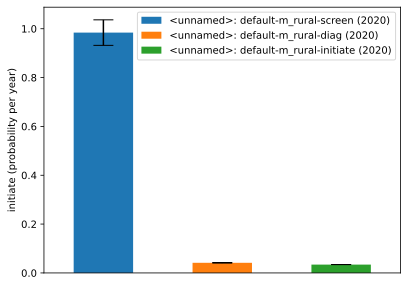

In [47]:
ensemble.plot_bars();

To perform this procedure seamlessly, instead of calling `P.run_sampled_sims`, you can instead call `Ensemble.run_sims`. The idea is that `Ensemble.run_sims` runs simulations specifically for that Ensemble - instead of returning results, it adds them to the Ensemble. Under the hood, it adds the results as they are generated without storing them internally. 

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:05, 18.59it/s]

  4%|▍         | 4/100 [00:00<00:05, 16.54it/s]

  6%|▌         | 6/100 [00:00<00:05, 17.79it/s]

  8%|▊         | 8/100 [00:00<00:05, 16.87it/s]

 10%|█         | 10/100 [00:00<00:05, 17.63it/s]

 12%|█▏        | 12/100 [00:00<00:05, 15.65it/s]

 14%|█▍        | 14/100 [00:00<00:05, 15.77it/s]

 16%|█▌        | 16/100 [00:00<00:05, 15.87it/s]

 18%|█▊        | 18/100 [00:01<00:06, 13.41it/s]

 20%|██        | 20/100 [00:01<00:06, 12.02it/s]

 22%|██▏       | 22/100 [00:01<00:06, 11.81it/s]

 24%|██▍       | 24/100 [00:01<00:06, 12.35it/s]

 26%|██▌       | 26/100 [00:01<00:05, 12.59it/s]

 28%|██▊       | 28/100 [00:01<00:05, 13.72it/s]

 30%|███       | 30/100 [00:02<00:04, 15.09it/s]

 32%|███▏      | 32/100 [00:02<00:05, 12.39it/s]

 34%|███▍      | 34/100 [00:02<00:05, 13.13it/s]

 36%|███▌      | 36/100 [00:02<00:04, 13.14it/s]

 38%|███▊      | 38/100 [00:03<00:09,  6.58it/s]

 40%|████      | 40/100 [00:03<00:07,  8.15it/s]

 42%|████▏     | 42/100 [00:03<00:06,  8.84it/s]

 44%|████▍     | 44/100 [00:03<00:05, 10.41it/s]

 46%|████▌     | 46/100 [00:03<00:04, 11.59it/s]

 48%|████▊     | 48/100 [00:03<00:04, 12.38it/s]

 50%|█████     | 50/100 [00:04<00:04, 12.02it/s]

 52%|█████▏    | 52/100 [00:04<00:03, 13.37it/s]

 54%|█████▍    | 54/100 [00:04<00:03, 12.09it/s]

 56%|█████▌    | 56/100 [00:04<00:04, 10.03it/s]

 58%|█████▊    | 58/100 [00:04<00:03, 11.31it/s]

 60%|██████    | 60/100 [00:04<00:03, 11.04it/s]

 62%|██████▏   | 62/100 [00:05<00:02, 12.75it/s]

 64%|██████▍   | 64/100 [00:05<00:03, 11.02it/s]

 66%|██████▌   | 66/100 [00:05<00:02, 12.17it/s]

 68%|██████▊   | 68/100 [00:05<00:02, 13.38it/s]

 70%|███████   | 70/100 [00:05<00:02, 14.67it/s]

 72%|███████▏  | 72/100 [00:05<00:02, 13.23it/s]

 74%|███████▍  | 74/100 [00:05<00:01, 13.84it/s]

 76%|███████▌  | 76/100 [00:06<00:01, 14.49it/s]

 78%|███████▊  | 78/100 [00:06<00:01, 14.61it/s]

 81%|████████  | 81/100 [00:06<00:01, 16.12it/s]

 83%|████████▎ | 83/100 [00:06<00:01, 16.06it/s]

 85%|████████▌ | 85/100 [00:06<00:00, 16.09it/s]

 87%|████████▋ | 87/100 [00:06<00:00, 14.05it/s]

 89%|████████▉ | 89/100 [00:07<00:00, 11.71it/s]

 91%|█████████ | 91/100 [00:07<00:00, 12.64it/s]

 93%|█████████▎| 93/100 [00:07<00:00, 14.00it/s]

 95%|█████████▌| 95/100 [00:07<00:00, 14.95it/s]

 97%|█████████▋| 97/100 [00:07<00:00, 15.98it/s]

 99%|█████████▉| 99/100 [00:07<00:00, 16.84it/s]

100%|██████████| 100/100 [00:07<00:00, 12.96it/s]

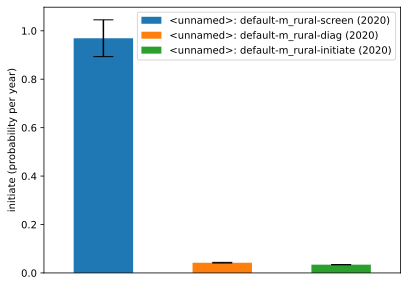

In [48]:
ensemble = at.Ensemble(store_minimal)
ensemble.run_sims(proj=P,parset=parset,progset=high_uncertainty_progset,progset_instructions=default_budget,n_samples=100)
ensemble.plot_bars();

Note that if you use `Ensemble.run_sims` is that a baseline simulation without sampling will automatically be performed and stored in the Ensemble. 

<div class="alert alert-success">

- Use `P.run_sampled_sims` if you can store all of the results in memory, which allows you to generate new Ensembles and plots without re-running the simulations    
- Use `Ensemble.run_sims` if you don't have enough memory to hold all of the results
</div>

## Parallization

Sampling is a trivially parallizable problem, and Atomica supports parallization of sampling. To run samples in parallel, simply set `parallel=True` when calling `Project.run_sampled_sims()` or `Ensemble.run_sims()`. See `test_ensemble_parallel.py` in the `tests` folder for an executable example. Note that on Windows, the calling code must be wrapped in `if __name__ == '__main__'`. 

## Experimental plots

The plots below are not fully developed but serve as examples to show possibilities that can be built upon as applications of Atomica progress. 

/home/vsts/work/1/s/atomica/results.py:1544: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(df, ax=ax, c=[colormap[x] for x in df["result"].values], diagonal="kde")


[<Figure size 614.4x460.8 with 9 Axes>]

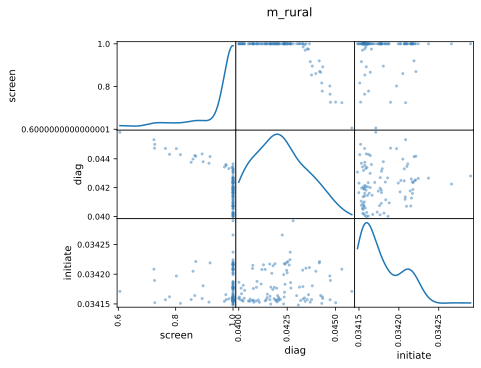

In [49]:
ensemble.pairplot()

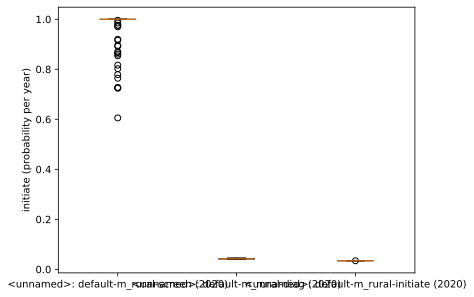

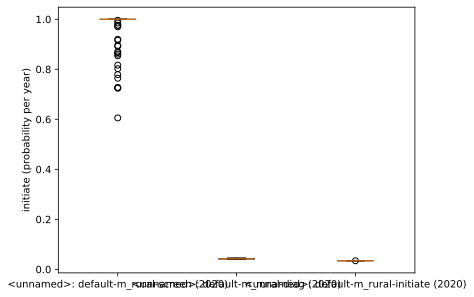

In [50]:
ensemble.boxplot()